# Melspectrogram + CNN for underwater audio classification

## Set up the environment

In [1]:
import csv
import glob
import os
import warnings
import librosa
import librosa.display
import numpy as np
import numpy.matlib as mtlib
import keras
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import Audio
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation

warnings.filterwarnings("ignore")
%matplotlib inline

print(os.getcwd())
os.chdir("/Users/sean/Documents/GitHub/AtelierML") # path to change if needed
os.getcwd()

from pymongo import MongoClient
from datetime import datetime as dt

Using TensorFlow backend.


/Users/sean/Documents/GitHub/AtelierML


## Some info on notebook, for logs



In [20]:
url = "mongodb://" # You should ask Sean for the https://stok.shinyapps.io/aml_shiny/ access
raise Exception("Please set a proper URL with access and remove this exception")
client = MongoClient(url)
db = client['atelier_aml']

In [2]:
username = "template"
atelier_number = 1
notes = "cnn_basic"

## Preprocess the data

### Explore the data

Folder containing all the WAV files. Each file contains only one occurence of the two species.
The extraction of the labels for each file is performed and stored in a CSV file

In [3]:
wav_dir = 'allWavSamples' 
labels = []
filenames = []
for i, wavFile in enumerate(glob.glob(os.path.join(os.getcwd(), wav_dir, '*.wav'))):  # for each WAV file
    # Extract wav filename
    filename = wavFile.split(os.sep)[-1]
    filenames.append(filename)
    labels.append(filename.split('.')[2])
with open('labelsTest.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerows(zip(filenames, labels))

In [4]:
np.unique(labels) # which class is in the dataset

array(['Bm', 'Eg'], dtype='<U2')

Audio sample to listen to

In [5]:
X, sample_rate = librosa.load(os.path.join(os.getcwd(), 'allWavSamples', filenames[24]), sr=2000)
print(filenames[24])
Audio(X, rate=sample_rate)

WAT_BP_2016-10-03T07_29_42.5.Bm.good.wav


### Encode labels

In [6]:
le = preprocessing.LabelEncoder()
le.fit(labels)
encodedLabels = le.transform(labels)

### Extract features (melspectrograms)

In [7]:
samplingRate = 2000
nOccur = len(labels)
n_mfccs = 40
max_len = 43 # precomputed
dataMFCC = np.zeros((n_mfccs, max_len, nOccur))
labels2 = np.zeros(nOccur, dtype=np.uint8)
k = 0

Compute melspectrogram for each sample

In [8]:
for file, label in zip(filenames, encodedLabels):
        print(file)

        X, sample_rate = librosa.load(os.path.join(os.getcwd(), 'allWavSamples', file), sr=samplingRate)

        melspectro = librosa.feature.melspectrogram(X, samplingRate, n_fft=4096, hop_length=2048, n_mels=n_mfccs)
        
        # zero padding
        if melspectro.shape[1] < max_len:
            pad = np.zeros((melspectro.shape[0], max_len - melspectro.shape[1]))
            melspectro = np.hstack((melspectro, pad))
        elif melspectro.shape[1] > max_len:
            melspectro = melspectro[:, :max_len]

        dataMFCC[:, :, k] = melspectro
        labels2[k] = label
        k += 1

WAT_HZ_2015-12-09T06_06_14.3.Bm.good.wav
WAT_BP_2016-10-04T08_34_40.8.Bm.poor.wav
WAT_HZ_2015-12-09T10_52_48.7.Bm.good.wav
WAT_BP_2016-10-02T08_16_01.8.Bm.poor.wav
HAT_A_2012-10-24T04_25_37.0.Bm.poor.wav
WAT_BP_2016-10-03T04_03_41.0.Bm.good.wav
WAT_HZ_2016-02-17T00_25_10.9.Bm.good.wav
WAT_HZ_2016-02-17T07_02_31.9.Bm.good.wav
WAT_BP_2016-10-02T02_46_31.1.Bm.poor.wav
WAT_BP_2016-10-04T10_25_50.7.Bm.poor.wav
WAT_BP_2016-10-03T00_40_11.0.Bm.poor.wav
WAT_BP_2016-10-03T04_06_17.2.Bm.good.wav
WAT_BP_2016-10-02T04_12_15.3.Bm.good.wav
HAT_A_2012-10-27T04_58_50.2.Bm.poor.wav
WAT_BP_2016-10-03T04_38_06.9.Bm.good.wav
WAT_BP_2016-10-02T04_05_39.2.Bm.poor.wav
WAT_BP_2016-10-03T22_52_57.4.Bm.poor.wav
WAT_BP_2016-10-02T07_39_29.3.Bm.poor.wav
HAT_A_2012-10-26T08_59_27.8.Bm.poor.wav
WAT_OC_2015-05-20T07_40_09.2.Eg.good.wav
WAT_BP_2016-10-02T03_06_51.8.Bm.poor.wav
WAT_HZ_2015-12-09T15_35_10.4.Bm.good.wav
HAT_A_2012-10-21T18_19_07.0.Bm.good.wav
WAT_BP_2016-10-04T00_09_11.8.Bm.poor.wav
WAT_BP_2016-10-03T07

WAT_BP_2016-10-03T07_18_09.2.Bm.good.wav
WAT_HZ_2015-12-09T05_46_37.0.Bm.good.wav
WAT_BP_2016-10-03T22_21_01.0.Bm.good.wav
HAT_A_2012-10-24T18_26_07.8.Bm.poor.wav
WAT_HZ_2016-01-09T20_16_21.5.Bm.poor.wav
WAT_HZ_2015-12-09T05_40_40.4.Bm.good.wav
WAT_HZ_2016-02-17T03_35_33.3.Bm.good.wav
HAT_A_2013-02-27T00_19_07.2.Eg.good.wav
HAT_A_2012-10-23T10_05_09.0.Bm.poor.wav
WAT_BP_2016-10-04T00_18_51.4.Bm.poor.wav
WAT_HZ_2016-01-09T10_02_40.1.Bm.good.wav
HAT_A_2012-10-21T11_49_24.9.Bm.good.wav
HAT_A_2012-10-24T03_34_20.6.Bm.poor.wav
WAT_HZ_2016-02-17T03_12_43.1.Bm.good(1).wav
WAT_BP_2016-10-04T05_02_01.1.Bm.poor.wav
WAT_HZ_2016-02-17T00_13_40.8.Bm.good.wav
WAT_HZ_2016-02-17T06_16_22.9.Bm.good.wav
WAT_BP_2016-10-02T02_43_02.0.Bm.good.wav
WAT_BP_2016-10-02T03_26_28.8.Bm.poor.wav
WAT_BP_2016-10-04T06_09_27.9.Bm.poor.wav
WAT_HZ_2016-01-09T19_50_22.5.Bm.poor.wav
WAT_BP_2016-10-03T23_49_14.2.Bm.poor.wav
WAT_OC_2015-05-20T06_26_17.6.Eg.good.wav
WAT_HZ_2015-12-09T11_48_32.7.Bm.good.wav
WAT_HZ_2016-01-09T

WAT_BP_2016-10-04T05_05_21.9.Bm.poor.wav
WAT_BP_2016-10-04T07_50_20.4.Bm.poor.wav
WAT_HZ_2016-02-17T08_38_13.2.Bm.good.wav
WAT_BP_2016-10-04T05_18_15.2.Bm.poor.wav
WAT_OC_2015-05-20T06_12_11.7.Eg.good.wav
HAT_A_2012-10-23T00_10_20.9.Bm.end.wav
WAT_BP_2016-10-03T03_48_36.1.Bm.poor.wav
WAT_BP_2016-10-04T05_34_25.5.Bm.poor.wav
HAT_A_2012-10-22T05_27_59.4.Bm.poor.wav
WAT_HZ_2016-01-09T11_18_03.5.Bm.poor.wav
WAT_HZ_2016-02-17T08_34_36.8.Bm.good.wav
WAT_BP_2016-10-03T22_43_32.8.Bm.good.wav
WAT_BP_2016-10-04T01_56_03.6.Bm.poor.wav
HAT_A_2012-10-24T12_36_19.8.Bm.poor.wav
HAT_A_2012-10-24T04_34_42.8.Bm.poor.wav
WAT_HZ_2016-02-17T02_37_13.1.Bm.good.wav
HAT_A_2012-10-27T11_31_04.9.Bm.poor.wav
HAT_A_2012-10-21T10_27_37.4.Bm.poor.wav
WAT_BP_2016-10-04T02_09_45.6.Bm.good.wav
WAT_HZ_2016-02-17T00_11_37.5.Bm.good.wav
WAT_BP_2016-10-03T13_39_29.6.Bm.poor.wav
WAT_BP_2016-10-03T03_42_15.1.Bm.poor.wav
WAT_OC_2015-05-20T07_43_06.1.Eg.good.wav
HAT_A_2012-10-25T01_53_47.4.Bm.poor.wav
WAT_HZ_2015-12-09T03_46_

WAT_HZ_2016-01-09T13_54_16.7.Bm.good.wav
HAT_A_2012-10-25T08_56_09.7.Bm.poor.wav
WAT_BP_2016-10-03T02_03_20.9.Bm.poor.wav
WAT_BP_2016-10-02T04_19_54.5.Bm.poor.wav
WAT_BP_2016-10-02T23_06_07.7.Bm.poor.wav
HAT_A_2013-09-09T11_18_30.3.Bm.poor.wav
WAT_BP_2016-10-03T07_00_53.2.Bm.poor.wav
WAT_OC_2015-05-20T06_36_24.6.Eg.good.wav
WAT_BP_2016-10-03T05_24_01.9.Bm.poor.wav
WAT_BP_2016-10-02T03_39_55.8.Bm.poor.wav
WAT_BP_2016-10-02T05_51_53.7.Bm.poor.wav
WAT_BP_2016-10-02T03_57_25.0.Bm.good.wav
WAT_HZ_2016-02-17T08_41_24.0.Bm.good.wav
WAT_BP_2016-10-02T10_51_18.6.Bm.poor.wav
WAT_BP_2016-10-02T05_57_54.2.Bm.good.wav
WAT_OC_2015-05-20T06_59_46.6.Eg.poor.wav
WAT_BP_2016-10-04T00_42_18.4.Bm.poor.wav
WAT_OC_2015-05-20T07_41_12.2.Eg.poor.wav
WAT_BP_2016-10-02T02_31_48.9.Bm.poor.wav
HAT_A_2012-10-22T22_06_16.1.Bm.poor.wav
WAT_HZ_2015-12-09T10_32_39.5.Bm.good.wav
WAT_HZ_2016-02-17T03_52_00.2.Bm.good.wav
WAT_BP_2016-10-04T00_32_38.8.Bm.poor.wav
WAT_BP_2016-10-03T04_14_30.3.Bm.good.wav
WAT_HZ_2016-02-17T0

WAT_BP_2016-10-03T06_12_56.4.Bm.poor.wav
WAT_HZ_2015-12-09T12_33_11.8.Bm.good.wav
WAT_HZ_2016-02-17T12_37_05.2.Bm.poor.wav
WAT_HZ_2015-12-09T11_24_00.8.Bm.good.wav
WAT_BP_2016-10-02T01_30_05.6.Bm.poor.wav
WAT_OC_2015-05-20T01_17_33.2.Eg.poor.wav
WAT_BP_2016-10-03T03_18_37.5.Bm.poor.wav
WAT_BP_2016-10-04T00_30_19.1.Bm.poor.wav
WAT_NC_2015-05-20T05_38_33.2.Eg.poor.wav
WAT_BP_2016-10-04T00_04_25.0.Bm.poor.wav
WAT_HZ_2016-02-17T04_20_15.7.Bm.good.wav
WAT_HZ_2016-01-09T12_10_40.7.Bm.poor.wav
WAT_BP_2016-10-04T04_13_50.9.Bm.poor.wav
WAT_BP_2016-10-03T01_48_44.9.Bm.poor.wav
HAT_A_2012-10-24T04_31_14.0.Bm.poor.wav
WAT_HZ_2015-12-09T13_51_40.2.Bm.good.wav
WAT_HZ_2015-12-09T13_53_49.9.Bm.good.wav
WAT_HZ_2015-12-09T06_07_27.9.Bm.good.wav
WAT_BP_2016-10-03T07_09_54.2.Bm.good.wav
WAT_BP_2016-10-03T02_57_28.1.Bm.poor.wav
WAT_BP_2016-10-02T06_20_25.9.Bm.poor.wav
HAT_A_2012-10-24T03_23_23.2.Bm.poor.wav
WAT_BP_2016-10-02T05_28_18.2.Bm.poor.wav
WAT_HZ_2016-02-17T07_42_54.4.Bm.good.wav
WAT_BP_2016-10-04T

WAT_HZ_2016-01-09T19_58_00.5.Bm.poor.wav
WAT_BP_2016-10-03T22_20_46.6.Bm.good.wav
WAT_HZ_2016-02-17T08_15_37.9.Bm.good.wav
WAT_BP_2016-10-03T07_02_38.3.Bm.good.wav
WAT_HZ_2016-02-17T06_22_09.2.Bm.good.wav
HAT_A_2012-10-24T12_24_12.2.Bm.poor.wav
WAT_HZ_2016-02-17T00_21_41.3.Bm.poor.wav
WAT_OC_2015-05-20T06_25_57.8.Eg.good.wav
WAT_BP_2016-10-04T02_06_21.0.Bm.good.wav
WAT_BP_2016-10-03T18_03_57.9.Bm.poor.wav
WAT_BP_2016-10-02T05_42_31.2.Bm.poor.wav
WAT_BP_2016-10-02T05_23_11.4.Bm.poor.wav
WAT_BP_2016-10-04T01_54_31.0.Bm.poor.wav
WAT_BP_2016-10-03T05_56_17.8.Bm.good.wav
WAT_BP_2016-10-04T10_03_03.5.Bm.poor.wav
WAT_BP_2016-10-03T12_08_49.0.Bm.poor.wav
WAT_BP_2016-10-04T01_42_54.6.Bm.poor.wav
HAT_A_2013-09-09T10_32_22.1.Bm.poor.wav
HAT_A_2012-10-24T16_47_49.1.Bm.poor.wav
WAT_OC_2015-05-20T06_21_02.9.Eg.good.wav
WAT_HZ_2015-12-09T11_21_57.8.Bm.good.wav
WAT_BP_2016-10-04T06_11_11.8.Bm.good.wav
WAT_HZ_2015-12-09T11_00_20.4.Bm.good.wav
WAT_BP_2016-10-03T07_58_37.0.Bm.poor.wav
HAT_A_2012-10-25T00

WAT_BP_2016-10-03T04_34_56.0.Bm.good.wav
WAT_BP_2016-10-04T06_12_31.7.Bm.good.wav
WAT_BP_2016-10-02T07_16_19.3.Bm.good.wav
WAT_BP_2016-10-02T07_48_35.3.Bm.poor.wav
WAT_BP_2016-10-04T07_51_43.3.Bm.poor.wav
HAT_A_2012-10-26T08_55_53.2.Bm.poor.wav
WAT_BP_2016-10-03T06_20_12.7.Bm.poor.wav
WAT_BP_2016-10-02T04_02_02.3.Bm.poor.wav
WAT_BP_2016-10-04T06_12_15.4.Bm.good.wav
WAT_OC_2015-05-20T06_06_03.8.Eg.good.wav
WAT_HZ_2016-01-09T11_22_46.1.Bm.good.wav
HAT_A_2012-10-25T00_24_06.5.Bm.poor.wav
WAT_BP_2016-10-04T01_32_21.9.Bm.poor.wav
WAT_HZ_2015-12-09T06_05_21.4.Bm.good.wav
WAT_HZ_2016-02-17T07_36_32.7.Bm.good.wav
WAT_BP_2016-10-04T06_16_11.1.Bm.good.wav
HAT_A_2012-10-22T06_28_21.8.Bm.poor.wav
WAT_HZ_2016-01-09T12_37_11.8.Bm.good.wav
WAT_HZ_2016-01-09T13_56_45.7.Bm.good.wav
WAT_BP_2016-10-04T01_13_19.7.Bm.poor.wav
WAT_HZ_2016-02-17T00_33_21.1.Bm.good.wav
HAT_A_2013-02-27T23_09_40.0.Eg.poor.wav
WAT_BP_2016-10-03T22_02_39.6.Bm.poor.wav
HAT_A_2012-10-26T10_47_43.6.Bm.poor.wav
WAT_BP_2016-10-02T07_

WAT_HZ_2015-12-09T11_23_45.0.Bm.good.wav
WAT_BP_2016-10-04T01_24_30.2.Bm.good.wav
WAT_HZ_2015-12-09T11_36_34.8.Bm.good.wav
WAT_HZ_2015-12-09T10_19_14.1.Bm.good.wav
WAT_BP_2016-10-02T06_21_31.8.Bm.poor.wav
WAT_BP_2016-10-02T07_27_16.6.Bm.poor.wav
WAT_BP_2016-10-04T07_43_32.9.Bm.poor.wav
WAT_HZ_2016-02-17T02_43_39.6.Bm.good.wav
WAT_HZ_2016-02-17T03_05_49.2.Bm.good.wav
HAT_A_2012-10-21T19_43_13.3.Bm.poor.wav
WAT_BP_2016-10-04T06_07_44.3.Bm.good.wav
WAT_BP_2016-10-04T06_25_27.9.Bm.poor.wav
WAT_HZ_2016-02-17T02_03_33.0.Bm.good.wav
WAT_BP_2016-10-02T08_11_13.0.Bm.poor.wav
WAT_BP_2016-10-04T05_49_04.2.Bm.poor.wav
WAT_OC_2015-05-20T06_53_28.0.Eg.good.wav
WAT_HZ_2015-12-09T06_04_15.8.Bm.good.wav
HAT_A_2012-10-24T10_09_21.4.Bm.poor.wav
WAT_HZ_2016-02-17T00_32_01.8.Bm.good.wav
HAT_A_2012-10-22T09_37_43.9.Bm.poor.wav
WAT_HZ_2016-01-09T20_17_38.1.Bm.poor.wav
WAT_HZ_2016-02-17T02_24_22.3.Bm.good.wav
WAT_BP_2016-10-02T03_26_11.9.Bm.poor.wav
WAT_BP_2016-10-03T00_36_41.5.Bm.poor.wav
HAT_A_2012-10-22T05

WAT_BP_2016-10-03T03_06_22.6.Bm.poor.wav
WAT_BP_2016-10-03T05_22_47.2.Bm.poor.wav
WAT_BP_2016-10-02T07_15_02.5.Bm.good.wav
WAT_BP_2016-10-04T05_28_26.6.Bm.poor.wav
HAT_A_2012-10-26T09_48_20.6.Bm.poor.wav
HAT_A_2012-10-27T05_27_28.1.Bm.poor.wav
WAT_BP_2016-10-04T02_54_50.9.Bm.poor.wav
WAT_HZ_2015-12-09T10_58_08.6.Bm.good.wav
WAT_BP_2016-10-03T06_51_59.9.Bm.poor.wav
WAT_HZ_2015-12-09T06_16_40.4.Bm.good.wav
WAT_HZ_2015-12-09T10_46_36.5.Bm.good.wav
WAT_BP_2016-10-03T03_45_06.3.Bm.good.wav
HAT_A_2012-10-25T08_24_43.6.Bm.good.wav
WAT_HZ_2016-02-17T02_42_38.7.Bm.good.wav
WAT_HZ_2016-01-09T11_32_06.7.Bm.good.wav
WAT_BP_2016-10-03T03_12_48.0.Bm.poor.wav
WAT_HZ_2016-01-09T09_28_26.7.Bm.good.wav
WAT_HZ_2016-02-17T03_34_14.3.Bm.poor.wav
WAT_OC_2015-05-20T08_10_18.3.Eg.poor.wav
WAT_BP_2016-10-04T02_21_13.7.Bm.good.wav
WAT_HZ_2016-02-17T01_16_31.4.Bm.good.wav
WAT_BP_2016-10-02T05_07_02.5.Bm.poor.wav
HAT_A_2013-09-09T14_00_29.5.Bm.poor.wav
WAT_HZ_2016-02-17T01_12_21.4.Bm.good.wav
WAT_BP_2016-10-03T00

WAT_HZ_2016-02-17T01_51_11.6.Bm.good.wav
WAT_HZ_2015-12-09T12_03_26.5.Bm.good.wav
HAT_A_2012-10-26T10_18_38.8.Bm.poor.wav
HAT_A_2012-10-22T22_04_53.0.Bm.poor.wav
WAT_HZ_2016-01-09T12_38_20.3.Bm.good.wav
WAT_BP_2016-10-02T10_52_29.8.Bm.poor.wav
WAT_HZ_2015-12-09T06_17_30.1.Bm.good.wav
WAT_HZ_2015-12-09T11_42_30.1.Bm.good.wav
WAT_BP_2016-10-04T00_13_46.7.Bm.good.wav
WAT_BP_2016-10-04T06_13_37.5.Bm.good.wav
WAT_BP_2016-10-03T03_55_06.5.Bm.good.wav
HAT_A_2012-10-22T03_27_53.5.Bm.poor.wav
HAT_A_2012-10-27T05_08_11.1.Bm.poor.wav
WAT_HZ_2016-02-17T08_40_02.3.Bm.good.wav
HAT_A_2012-10-21T05_20_48.3.Bm.poor.wav
HAT_A_2012-10-27T04_50_20.2.Bm.poor.wav
HAT_A_2012-10-21T09_44_35.9.Bm.poor.wav
HAT_A_2012-10-25T00_29_34.6.Bm.poor.wav
WAT_HZ_2016-02-17T06_12_27.0.Bm.good.wav
WAT_OC_2015-05-20T03_03_59.9.Eg.poor.wav
WAT_BP_2016-10-03T18_25_04.0.Bm.poor.wav
WAT_BP_2016-10-03T21_34_37.1.Bm.poor.wav
WAT_BP_2016-10-02T06_30_49.0.Bm.poor.wav
WAT_BP_2016-10-02T07_36_11.2.Bm.good.wav
WAT_BP_2016-10-02T06_09_

WAT_BP_2016-10-04T02_57_33.4.Bm.poor.wav
WAT_BP_2016-10-03T06_28_15.2.Bm.good.wav
WAT_HZ_2016-02-17T02_33_15.4.Bm.good.wav
WAT_BP_2016-10-04T07_02_31.9.Bm.poor.wav
HAT_A_2013-09-09T09_41_04.0.Bm.poor.wav
WAT_BP_2016-10-04T04_04_20.3.Bm.poor.wav
WAT_HZ_2015-12-09T06_18_49.7.Bm.good.wav
HAT_A_2012-10-27T10_09_00.2.Bm.good.wav
WAT_HZ_2016-02-17T03_35_23.1.Bm.good.wav
WAT_OC_2015-05-20T07_42_29.2.Eg.good.wav
WAT_BP_2016-10-02T07_01_42.4.Bm.poor.wav
WAT_HZ_2015-12-09T07_40_23.3.Bm.good.wav
HAT_A_2012-10-23T10_21_48.5.Bm.poor.wav
WAT_BP_2016-10-03T00_40_29.0.Bm.poor.wav
WAT_OC_2015-05-20T06_50_57.9.Eg.good.wav
WAT_HZ_2016-02-17T01_43_53.6.Bm.good.wav
WAT_HZ_2015-12-09T12_09_33.4.Bm.good.wav
WAT_OC_2015-05-20T06_07_23.7.Eg.good.wav
WAT_BP_2016-10-02T08_16_39.0.Bm.good.wav
WAT_HZ_2016-01-09T11_24_46.3.Bm.good.wav
HAT_A_2012-10-24T09_13_00.4.Bm.good.wav
HAT_A_2013-09-09T20_37_45.1.Bm.poor.wav
WAT_BP_2016-10-02T04_15_26.0.Bm.good.wav
HAT_A_2013-09-09T20_24_43.5.Bm.good.wav
WAT_BP_2016-10-04T01_1

HAT_A_2012-10-21T09_37_17.9.Bm.poor.wav
HAT_A_2013-09-09T09_44_36.7.Bm.poor.wav
WAT_BP_2016-10-02T02_19_53.4.Bm.poor.wav
WAT_HZ_2015-12-09T06_06_26.9.Bm.good.wav
HAT_A_2012-10-24T01_17_38.1.Bm.poor.wav


Save all the computed features and corresponding labels

In [9]:
fileMatFeats = 'dataMatTest1.npy'
fileLabels = 'labelsArrTest1.npy'
fileLabelEnco = 'labelEncoTest1.npy'

dataToStore = dataMFCC.swapaxes(0, 2).swapaxes(1, 2).reshape(-1, max_len * n_mfccs)
np.save(fileMatFeats, dataToStore)
np.save(fileLabels, labels2)
np.save(fileLabelEnco, le)

Load features and labels

In [10]:
melspectros = np.load(fileMatFeats)
labels = np.load(fileLabels)
le = np.load(fileLabelEnco)

scaler = StandardScaler()
concatMelspectros = scaler.fit_transform(melspectros)
del melspectros

## Train / Test a network

### Set up cross-validation

Split data in train/test datasets for cross-validation.
Other methods in Python exists (train_test_split, ShufffleSplit, ...) but this one 
preserves the percentage of samples for each class. However, the datasets are still really unbalanced...

In [11]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(concatMelspectros, labels)
numClasses = len(np.unique(labels))

### Train / Test a network

#### Notions

##### Convolution

Convolution filters are used in the initial layers to extract high level features from an image. It applies a matrix known as the kernel to the input tensor to produce a set of matrices known as the feature maps.

![](convolutionEq.png)

Example for image convolution

![](convoluCustom.png)

##### Relu Function

Text(0.5, 1.0, 'ReLU function: ReLU(x)=max(0,x)')

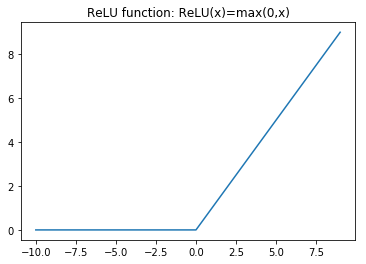

In [13]:
xax = np.array([i for i in range(-10, 10)])
ax = plt.plot([i for i in range(-10, 10)], np.maximum(0, xax))
plt.title('ReLU function: ReLU(x)=max(0,x)')

 One benefit from ReLU: it computes faster.

##### Softmax output layer

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x.
        https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

Let's take an example of what softmax function does. It puts a stack of numbers into a set of probability scores that all sum up to one. The index with the higher value is our predicted class. 

In [15]:
outputFC = [1, 10, 4, 5, 8, 3]
softmax(outputFC)

array([1.07726235e-04, 8.72914725e-01, 2.16373927e-03, 5.88165315e-03,
       1.18136162e-01, 7.95995195e-04])

##### Batch size

This is the number of samples (here images) per execution loop. Limited by te available memory. Generally, smaller batch size are preferred

##### Epoch

This is the number of iterations on the train / test sets.

In [16]:
def prepare_report(report, conf_matrix, accuracy, atelier_number, user="anonymous", notes=""):
    c_m = {str(i): {str(j): str(y) for j, y in enumerate(x)} for i, x in enumerate(conf_matrix)}
    report["conf_matrix"] = c_m
    report["accuracy"] = accuracy
    report["user"] = user
    report["datetime"] = dt.now().strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    report["notes"] = notes
    report["atelier_number"] = atelier_number
    return report

In [22]:
j = 0
for train_index, test_index in sss.split(concatMelspectros, labels):
    print('\nFold ', j)
    # Split in train / test sets for the ith fold
    X_train, X_test = concatMelspectros[train_index], concatMelspectros[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Reshape all feature vectors in tensors to feed the network
    x_train = np.reshape(X_train, (len(X_train), n_mfccs, max_len,1))
    x_test = np.reshape(X_test, (len(X_test), n_mfccs, max_len,1))

    # Convert labels to categorical ones ( binary class matrix )
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    ## Build network
    model = Sequential()
    # 1st block 
    model.add(Convolution2D(filters=8, kernel_size=7,
                    input_shape=x_train.shape[1:])) # -> see Notions.Convolution
    convout1 = Activation('relu') # -> see Notions.ReLU
    model.add(convout1)
    # 2nd block
    model.add(Flatten())
    model.add(Dense(200))
    fcout2 = Activation('relu')
    model.add(fcout2)
    # Decision
    model.add(Dense(numClasses))
    outputDeci = Activation('softmax') # -> see Notions.Softmax
    model.add(outputDeci)
    # Optimizer
    opt = keras.optimizers.SGD(lr=0.5)
    # Generate the network
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

    # Train model
    model.fit(x_train, y_train,
              batch_size=32,
              epochs=5,
              shuffle=True,
              verbose=2,
              validation_data=(x_test, y_test))
    # Test model of this fold and print loss and accuracy on test set
    loss, accuracy = model.evaluate(x=x_test, y=y_test)
    print("\n model test loss is " + str(loss) + " accuracy is " + str(accuracy))

    #Metrics
    y_softmax = model.predict(x_test)  # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = y_test.argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))
    print(confusion_matrix(test_y, y_hat))
    print("\n Accuracy score is:" + str(accuracy_score(test_y, y_hat)))

    #Send to logs
    cr = classification_report(test_y, y_hat, output_dict=True)
    conf_matrix = confusion_matrix(test_y, y_hat)
    acc_score = accuracy_score(test_y, y_hat)
    rep = prepare_report(cr, conf_matrix, acc_score, atelier_number, username, notes)
    db.attempts.insert_one(rep)
       
    j += 1


Fold  0
Train on 1917 samples, validate on 480 samples
Epoch 1/5
 - 4s - loss: 0.3190 - acc: 0.9118 - val_loss: 0.2009 - val_acc: 0.9313
Epoch 2/5
 - 3s - loss: 0.1450 - acc: 0.9604 - val_loss: 0.1642 - val_acc: 0.9458
Epoch 3/5
 - 3s - loss: 0.0889 - acc: 0.9734 - val_loss: 0.0784 - val_acc: 0.9854
Epoch 4/5
 - 3s - loss: 1.1398 - acc: 0.9254 - val_loss: 1.3770 - val_acc: 0.9146
Epoch 5/5
 - 3s - loss: 1.3707 - acc: 0.9150 - val_loss: 1.3769 - val_acc: 0.9146
480/480 [==============================] - 0s 692us/step

 model test loss is 1.3769148906071982 accuracy is 0.9145833333333333
              precision    recall  f1-score   support

           0       0.91      1.00      0.96       439
           1       0.00      0.00      0.00        41

   micro avg       0.91      0.91      0.91       480
   macro avg       0.46      0.50      0.48       480
weighted avg       0.84      0.91      0.87       480

[[439   0]
 [ 41   0]]

 Accuracy score is:0.9145833333333333

Fold  1
Train on

### Explore the last created network

In [24]:
# Print the structure of the network
model.summary()
# Nber of params conv2d -> (7 * 7 * 1 + 1) * 8 = 400
# Nber of params dense -> 10064*200 + 200 = 2013000
# Nber of params dense2 -> 200 * 2 + 2 = 402

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 34, 37, 8)         400       
_________________________________________________________________
activation_13 (Activation)   (None, 34, 37, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10064)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               2013000   
_________________________________________________________________
activation_14 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 402       
_________________________________________________________________
activation_15 (Activation)   (None, 2)                 0         
Total para